In [1]:
import sys
sys.path.append('../src/')

In [2]:
# TODO: Add code definitions here
import json
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
from learning import NetworkBGP
%matplotlib inline

## Opening Data

In [3]:
with open('../data/extracted_one_min_nov15.json') as f:
    full = json.load(f)
full[:3]

[{'time': 1542313320,
  'composite': {'prefix': '2620:0:2f0::', 'mask': 48, 'dest': 32629},
  'full_path': [63956, 4637, 174, 32629]},
 {'time': 1542313320,
  'composite': {'prefix': '2a0b:d080::', 'mask': 32, 'dest': 205747},
  'full_path': [63956, 13030, 60804, 174, 6830, 205747]},
 {'time': 1542313320,
  'composite': {'prefix': '94.185.102.0', 'mask': 24, 'dest': 198013},
  'full_path': [2914, 3356, 3549, 5392, 5392, 198013]}]

## Creating a Network

In [85]:
net_manager = NetworkBGP(full, 400, 0.1)

There are 8768 messages to be labeled
There are 2191 messages to be labeled


In [86]:
net_manager.Xtrain[:3]

tensor([[-1.6641,  2.5938,  1.3552, -0.4355],
        [-1.6641,  2.5983,  0.3081,  1.4532],
        [-1.6641, -0.3952, -0.2154,  1.3688]], dtype=torch.float64)

In [87]:
net_manager.net

DistinctNN(
  (h1): Linear(in_features=4, out_features=400, bias=True)
  (a1): ReLU()
  (h2): Linear(in_features=400, out_features=400, bias=True)
  (a2): ReLU()
  (raw_out): Linear(in_features=400, out_features=2, bias=True)
  (out_act): LogSoftmax()
)

## Training the Network

In [88]:
start = time.time()
losses = net_manager.train_network(num_iterations=500)
print('Training took {}'.format(time.time() - start))

Training took 133.29466700553894


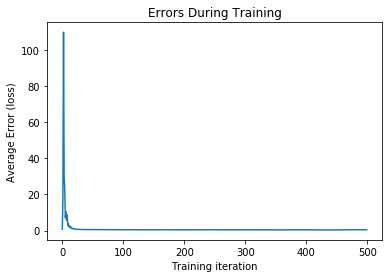

In [89]:
plt.plot(losses)
plt.ylabel('Average Error (loss)')
plt.xlabel('Training iteration')
plt.title('Errors During Training')
plt.show()

In [91]:
losses[-1]

[array(0.38606398)]

## Testing the Network
### Data used for Training

In [92]:
alpha=0.1

In [93]:
predicted = torch.max(net_manager.net(net_manager.Xtrain), 1)[1].numpy()
actual = net_manager.Ttrain.numpy()

In [94]:
predicted

array([1, 1, 1, ..., 0, 1, 1])

In [95]:
net_manager.net(net_manager.Xtrain)

tensor([[-3.6112, -0.0274],
        [-0.8040, -0.5934],
        [-3.1458, -0.0440],
        ...,
        [-0.0401, -3.2366],
        [-0.8320, -0.5712],
        [-0.8320, -0.5712]],
       dtype=torch.float64, grad_fn=<LogSoftmaxBackward>)

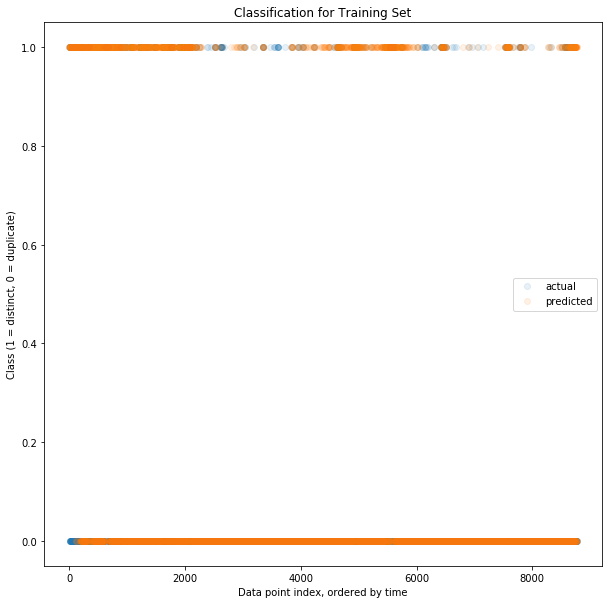

In [96]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(actual, 'o', alpha=alpha, label='actual')
ax.plot(predicted, 'o', alpha=alpha, label='predicted')
plt.legend()
plt.ylabel('Class (1 = distinct, 0 = duplicate)')
plt.xlabel('Data point index, ordered by time')
plt.title('Classification for Training Set')
plt.show()

In [97]:
np.sum(predicted == actual.flatten()) / len(predicted)

0.8656478102189781

In [98]:
actual_ones = np.where(actual.flatten() == 1)[0]
should_be_ones = np.take(predicted, actual_ones)
actual_ones = np.take(actual, actual_ones)
sum(should_be_ones == actual_ones) / len(actual_ones)

0.790633608815427

### On New Data

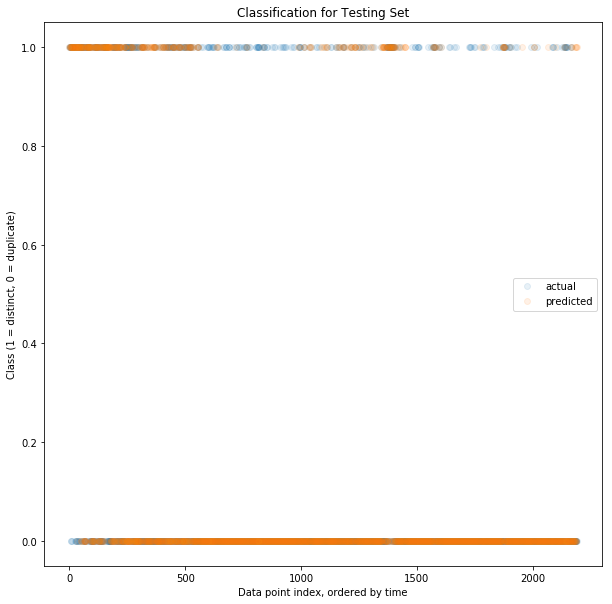

In [99]:
predicted = torch.max(net_manager.net(net_manager.Xtest), 1)[1].numpy()
actual = net_manager.Ttest.numpy()
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(actual, 'o', alpha=alpha, label='actual')
ax.plot(predicted, 'o', alpha=alpha, label='predicted')
plt.legend()
plt.ylabel('Class (1 = distinct, 0 = duplicate)')
plt.xlabel('Data point index, ordered by time')
plt.title('Classification for Testing Set')
plt.show()

In [100]:
np.sum(predicted == actual.flatten()) / len(predicted)

0.8229119123687814

In [101]:
actual_ones = np.where(actual.flatten() == 1)[0]
should_be_ones = np.take(predicted, actual_ones)
actual_ones = np.take(actual, actual_ones)
sum(should_be_ones == actual_ones) / len(actual_ones)

0.49047619047619045